# Algoritmos de clustering

## Alunos

- João Vitor Vendemiato Fatoretto - 199944
- Natan Beltrão da Cunha Pevidor Carvalho - 184972

## Resumo

Neste projeto, implementamos dois algoritmos não-supervisionados de clustering: k-means e dbscan. Executamos os algoritmos em duas bases de dados: uma bidimensional fornecida no enunciado do projeto e uma fornecida pelo site Our World in Data de dados sobre COVID-19, disponível em https://ourworldindata.org/coronavirus.

## Divisão de tarefas

### João Vitor

- Processamento dados multidimensionais
- Normalização dos dados
- Método da silhueta

### Natan

- Processamento dados bidimensionais
- Algoritmo k-means
- Algoritmo dbscan

In [1]:
import matplotlib.pyplot as plot
import numpy as np
import scipy.spatial.distance as spsd
import json
from sklearn.decomposition import PCA

## Dados bidimensionais

O primeiro passo foi separar os dados utilizados para treinamento dos modelos e os dados que serão usados para validação dos mesmos.

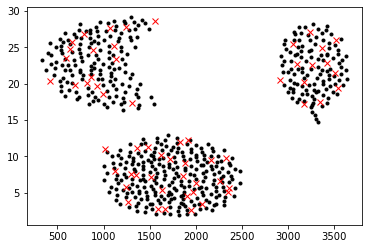

In [2]:
data = np.loadtxt('cluster.dat')

testing = np.array([ item for index, item in enumerate(data) if index % 10 == 0 ])
training = np.array([ item for index, item in enumerate(data) if index % 10 >= 1 ])

plot.plot(training[:,0], training[:,1], '.', color='black')
plot.plot(testing[:,0], testing[:,1], 'x', color='red')
plot.show()

## K-means

Em seguida, implementamos o algoritmo k-means, que separa os dados em clusters caracterizados por um ponto central. Para inicializar o algoritmo, é necessário um parâmetro **k**, que determina quantos clusters diferentes serão gerados.

O primeiro passo é gerar **k** pontos para definirem os clusters inicialmente. Para isso, adotamos a inicialização da implementação k-means++. Nela, o primeiro ponto é escolhido aleatoriamente dentre os dados fornecidos e os próximos também são escolhidos de forma aleatória, porém com maior chance quantos mais distante estiver dos outros pontos já escolhidos.

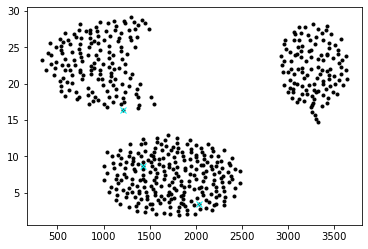

In [3]:
def pick_cluster_centers(array, k):
    centers = []
    for i in range(k):
        p_dist = np.ones(array.shape[0])
        for j in range(array.shape[0]):
            if centers:
                distances = spsd.cdist(np.array([array[j]]), centers)
                p_dist[j] = min(distances)[0]
        p_dist /= sum(p_dist)
        ai = np.random.choice(array.shape[0], p = p_dist)
        centers.append(array[ai])
    return np.array(centers)

centers = pick_cluster_centers(training, 3)

plot.plot(training[:,0], training[:,1], '.', color='black')
plot.plot(centers[:,0], centers[:,1], 'x', color='cyan')
plot.show()

A seguir, implementamos o restante do algoritmo k-means: a partir dos centros gerados, classificar cada um dos pontos em relação ao centro mais próximo. Depois disso, recalcular os centros a partir da posição média dos pontos que pertencem ao seu respectivo cluster. Repetimos o processo até que os centros não se movam mais do que o parâmetro **diff**, padronizado com o valor 0.1.

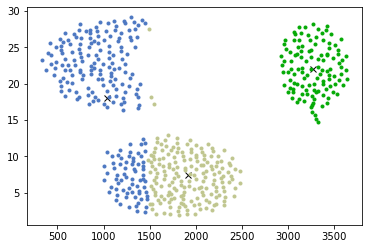

In [4]:
def get_cluster_data_kmeans(array, centers):
    distances = spsd.cdist(array, centers)
    clusterization = np.argmin(distances, axis=1)
    clusters = {}
    for i in range(centers.shape[0]):
        indices = np.where(clusterization == i)
        clusters[i] = np.take(array, indices, 0)
    return clusters

def kmeans(array, k, diff=0.1):
    centers = pick_cluster_centers(array, k)

    changed = True
    while (changed):
        clusters = get_cluster_data_kmeans(array, centers)
        
        new_centers = np.empty(centers.shape)
        for i in range(k):
            new_centers[i] = np.mean(clusters[i], 1)
        
        if abs(np.sum(new_centers - centers)) > diff:
            centers = new_centers
        else:
            changed = False
    return centers

cluster_centers = kmeans(training, 3)
clusters = get_cluster_data_kmeans(training, cluster_centers)
plot.plot(cluster_centers[:,0], cluster_centers[:,1], 'x', color='black')
for i in clusters:
    plot.plot(clusters[i][0,:,0], clusters[i][0,:,1], '.', color=np.random.rand(3,))
plot.show()

Como podemos observar no gráfico acima, a classificação dos clusters parece estar incorreta. Isso se deve ao fato de que os dados têm uma amplitude muito maior no eixo x do que no eixo y, o que faz com que o eixo x possua um "peso" maior no algoritmo k-means.

Para resolver esse problema, implementamos a normalização dos dados e, assim, obtivemos uma classificação mais precisa.

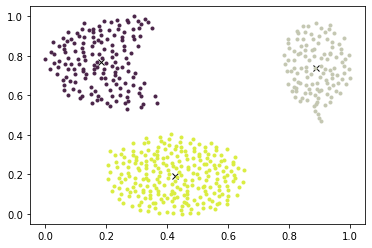

In [5]:
def normalize(array):
    min_by_feature = array.min(axis=0)
    max_by_feature = array.max(axis=0)
    
    for j in range(0, len(array[0])):
        for i in range(0, len(array)):
            array[i, j] = (array[i, j] - min_by_feature[j]) / (max_by_feature[j] - min_by_feature[j])
    
    return array

new_training = normalize(training)
new_centers = kmeans(new_training, 3, 0.0001)
new_clusters = get_cluster_data_kmeans(new_training, new_centers)

plot.plot(new_centers[:,0], new_centers[:,1], 'x', color='black')
for i in new_clusters:
    plot.plot(new_clusters[i][0,:,0], new_clusters[i][0,:,1], '.', color=np.random.rand(3,))
plot.show()

## DBSCAN

A seguir implementamos o método dbscan, uma alternativa ao k-means para gerar a clusterização dos dados.

O método dbscan inicia separando os dados no centro de um cluster dos dados na borda. Para isso, precisamos informar dois parâmetros:

- **e**: o raio usado para decidir se dois pontos são vizinhos
- **m**: a quantidade de vizinhos necessária para que um ponto seja considerado central

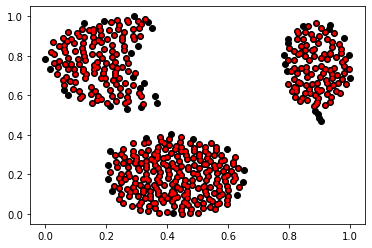

In [6]:
def get_core_points(array, e, m):
    cores = []
    distances = spsd.cdist(array, array)
    for i in range(distances.shape[0]):
        neighbors = np.where(distances[i] < e)
        if neighbors[0].size - 1 >= m:
            cores.append(array[i])
    return np.array(cores)

cores = get_core_points(new_training, 0.06, 8)

plot.plot(new_training[:,0], new_training[:,1], 'o', color='black')
plot.plot(cores[:,0], cores[:,1], '.', color='red')
plot.show()

Após testar alguns valores, optamos pelos valores 0.06 para **e** e 8 para **m**. Após isso, implementamos o restante do algoritmos do dbscan, que agrupa pontos centrais vizinhos em clusters e identifica um ponto como pertencente a um cluster se ele está a uma distância menor do que **e** de um ponto central deste.

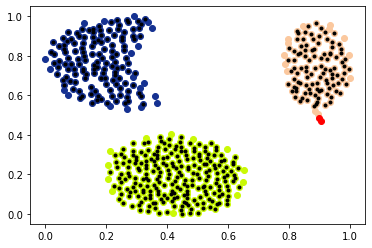

In [7]:
def get_cluster(clusters, core):
    for i in range(len(clusters)):
        for c in clusters[i]:
            if np.array_equal(c, core):
                return i
    return None

def add_core_to_cluster(clusters, cores, neighbors, core_index, cluster_index = None):
    if get_cluster(clusters, cores[core_index]) is not None:
        return
    
    if cluster_index is None:
        clusters.append([cores[core_index]])
        cluster_index = len(clusters) - 1
    else:
        clusters[cluster_index].append(cores[core_index])
    
    for i in range(neighbors[core_index].size):
        add_core_to_cluster(clusters, cores, neighbors, neighbors[core_index][i], cluster_index)

def dbscan(array, e, m):
    cores = get_core_points(array, e, m)
    distances = spsd.cdist(cores, cores)
    neighbors = []
    for i in range(distances.shape[0]):
        neighbors.append(np.where(distances[i] < e)[0])
    
    clusters = []
    for i in range(cores.shape[0]):
        add_core_to_cluster(clusters, cores, neighbors, i)
    
    for i in range(len(clusters)):
        clusters[i] = np.array(clusters[i])
    return clusters

def get_cluster_data_dbscan(array, cores, e):
    cluster_distances = []
    for i in range(len(cores)):
        distances = spsd.cdist(array, cores[i])
        cluster_distances.append(np.min(distances, axis=1))
    cluster_distances = np.array(cluster_distances)
    clusterization = np.argmin(cluster_distances, axis=0)
    
    clusters = {}
    outliers = []
    for i in range(len(cores)):
        clusters[i] = []
    
    for i in range(clusterization.size):
        if cluster_distances[clusterization[i],i] < e:
            clusters[clusterization[i]].append(array[i])
        else:
            outliers.append(array[i])
    
    for i in range(len(cores)):
        clusters[i] = np.array([clusters[i]])
    outliers = np.array(outliers)

    return (clusters, outliers)

cluster_cores = dbscan(new_training, 0.06, 8)
clusters, outliers = get_cluster_data_dbscan(new_training, cluster_cores, 0.06)

for i in range(len(clusters)):
    plot.plot(clusters[i][0,:,0], clusters[i][0,:,1], 'o', color=np.random.rand(3,))
    plot.plot(cluster_cores[i][:,0], cluster_cores[i][:,1], '.', color='black')

if outliers.size:
    plot.plot(outliers[:,0], outliers[:,1], 'o', color='red')

plot.show()

Uma diferença importante entre os métodos k-means e dbscan é que o dbscan é capaz de detectar outliers, isto é, dados que não estão a uma distância **e** de nenhum centro de cluster. Podemos identificar no gráfico (em vermelho) dois pontos que foram identificados como outliers.

## Dados multidimensionais

Para nossos dados multidimensionais, escolhemos os dados fornecidos pelo site Our World in Data (https://ourworldindata.org/coronavirus). Optamos por classificar os países por total de mortos por mês. Como esses dados não estavam disponíveis de forma direta, tivemos que implementar o seguinte algoritmo para obtê-los:

In [8]:
def covid_dataset_cleaner(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)

    matriz = {}
    notCountries = ["World", "Africa", "Europe", "European Union", "Asia", "North America", "South America", "Oceania", "International"]

    for country in data:
        if not (data[country]['location'] in notCountries):
            location = data[country]['location']
            newCountry = []
            
            lastMonth = str(data[country]['data'][0]['date'][5]) + str(data[country]['data'][0]['date'][6]) + '/' + str(data[country]['data'][0]['date'][2]) + str(data[country]['data'][0]['date'][3])
            lastData = []
            
            if lastMonth == '04/20':
                newCountry.append([0, 0, '2020-03-31'])
            
            elif lastMonth == '05/20':
                newCountry.append([0, 0, '2020-03-31'])
                newCountry.append([0, 0, '2020-04-30'])

            for daysInformation in data[country]['data']:
                newMonth = str(daysInformation['date'][5]) + str(daysInformation['date'][6]) + '/' + str(daysInformation['date'][2]) + str(daysInformation['date'][3])

                if newMonth == '01/20' or newMonth == '02/20':
                    lastMonth = '03/20'
                    continue

                if lastMonth != newMonth:
                    newCountry.append(lastData)

                deaths = 0
                total_deaths = 0
                if 'total_deaths_per_million' in daysInformation:
                    total_deaths = daysInformation['total_deaths_per_million']
                    if len(newCountry):
                        deaths = total_deaths - newCountry[len(newCountry) - 1][1]
                    else:
                        deaths = total_deaths

                lastMonth = newMonth
                lastData =  [deaths, total_deaths, daysInformation['date']]
                
            if len(newCountry) == 13:
                matriz[location] = newCountry    

    return matriz


covid_dataset = covid_dataset_cleaner('covid-data.json')

countries = list(covid_dataset.keys())
deaths = []
for country in countries:
    deaths.append([])
    i = len(deaths) - 1
    for death_data in covid_dataset[country]:
        deaths[i].append(death_data[0])
deaths = np.array(deaths)
print(deaths)

[[1.03000e-01 1.54100e+00 4.98400e+00 ... 5.36900e+00 1.10400e+00
  1.05400e+00]
 [5.21200e+00 5.56000e+00 6.95000e-01 ... 6.91500e+01 1.44555e+02
  1.52547e+02]
 [1.00300e+00 9.25900e+00 4.62900e+00 ... 3.07900e+00 2.09800e+00
  2.50800e+00]
 ...
 [0.00000e+00 6.70000e-02 2.61500e+00 ... 1.68000e-01 6.37000e-01
  8.51600e+00]
 [0.00000e+00 1.63000e-01 2.18000e-01 ... 2.03990e+01 1.78410e+01
  6.36400e+00]
 [6.70000e-02 2.02000e-01 0.00000e+00 ... 5.74590e+01 1.65510e+01
  4.03700e+00]]


Para validarmos os algoritmos, precisamos novamente separar os dados de treino dos dados de teste. Também normalizamos os dados separados previamente.

In [9]:
testing_countries = countries[0::10]
testing_deaths = normalize(np.array([ item for index, item in enumerate(deaths) if index % 10 == 0 ]))

training_countries = [country for country in countries if country not in testing_countries]
training_deaths = normalize(np.array([ item for index, item in enumerate(deaths) if index % 10 >= 1 ]))
print("Testing:")
print(testing_countries)
print()
print("Training:")
print(training_countries)

Testing:
['Afghanistan', 'Azerbaijan', 'Bolivia', 'Canada', "Cote d'Ivoire", 'Ecuador', 'France', 'Guinea-Bissau', 'Iraq', 'Kuwait', 'Luxembourg', 'Moldova', 'New Zealand', 'Papua New Guinea', 'Saint Kitts and Nevis', 'Singapore', 'Suriname', 'Trinidad and Tobago', 'Vatican']

Training:
['Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'Gabon', 'Gambia', 'Geor

In [10]:
centers = kmeans(training_deaths, 5, diff=0.00001)
print(spsd.cdist(centers, centers))
clusters = get_cluster_data_kmeans(training_deaths, centers)
for i in clusters:
    print(clusters[i].shape)

[[0.         1.40155609 1.16830791 1.18806703 0.73294762]
 [1.40155609 0.         1.24807634 1.28486426 0.80893563]
 [1.16830791 1.24807634 0.         1.11005881 0.93350135]
 [1.18806703 1.28486426 1.11005881 0.         0.99312103]
 [0.73294762 0.80893563 0.93350135 0.99312103 0.        ]]
(1, 119, 13)
(1, 8, 13)
(1, 2, 13)
(1, 6, 13)
(1, 32, 13)


In [17]:
cores = dbscan(training_deaths, 0.1, 2)
clusters, outliers = get_cluster_data_dbscan(training_deaths, cores, 0.1)
print(len(cores))
print(len(outliers))

2
79


5


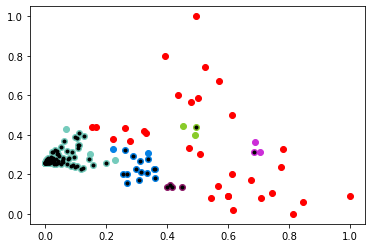

In [15]:
pca = PCA(n_components=2)
training_deaths_2D = normalize(pca.fit_transform(training_deaths))

cluster_cores = dbscan(training_deaths_2D, 0.05, 2)
clusters, outliers = get_cluster_data_dbscan(training_deaths_2D, cluster_cores, 0.05)

for i in range(len(clusters)):
    color = np.random.rand(3,)
    plot.plot(clusters[i][0,:,0], clusters[i][0,:,1], 'o', color=color)
    plot.plot(cluster_cores[i][:,0], cluster_cores[i][:,1], '.', color='black')

if outliers.size:
    plot.plot(outliers[:,0], outliers[:,1], 'o', color='red')

print(len(clusters))